<a href="https://colab.research.google.com/github/xiaoguowei/test/blob/main/Transformer_en_zh_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_datasets
!git clone https://github.com/xiaoguowei/test.git

Cloning into 'test'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 23 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [ ]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import clear_output
import tensorflow_datasets as tfds
import tensorflow as tf

# **路徑**



In [ ]:
output_dir = "test/nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab") #已有英文字典的路径 test/nmt/en_vocab
zh_vocab_file = os.path.join(output_dir, "zh_vocab") ##已有中文字典的路径 test/nmt/zh_vocab
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads" #下载数据

if not os.path.exists(output_dir):
  os.makedirs(output_dir)



#**加載數據**

wmt19_translate/zh-en


*   newscommentary_v14(311556筆)



In [ ]:
list_tfds = tfds.list_builders()
tfds_zh_en=tfds.builder("wmt19_translate/zh-en")
config = tfds.translate.wmt.WmtConfig(
  version=tfds.core.Version('0.0.3', experiments=None),
  language_pair=("zh", "en"),
  subsets={
    tfds.Split.TRAIN: ["newscommentary_v14"]
  }
)

builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)
clear_output()

train_examples = builder.as_dataset(split=tfds.Split.TRAIN, as_supervised=True)
print("數據集總共有：",len(train_examples))
# for en,zh in train_examples.take(1): #[en,zh]
#     print("Datasets_en原始數據: ", en)
#     print("Datasets_zh原始數據: ", zh)
#     print("解碼後的en: ",en.numpy().decode("utf-8"))
#     print("解碼後的zh: ",zh.numpy().decode("utf-8"))

數據集總共有： 311556
Datasets_en原始數據:  tf.Tensor(b'The fear is real and visceral, and politicians ignore it at their peril.', shape=(), dtype=string)
Datasets_zh原始數據:  tf.Tensor(b'\xe8\xbf\x99\xe7\xa7\x8d\xe6\x81\x90\xe6\x83\xa7\xe6\x98\xaf\xe7\x9c\x9f\xe5\xae\x9e\xe8\x80\x8c\xe5\x86\x85\xe5\x9c\xa8\xe7\x9a\x84\xe3\x80\x82 \xe5\xbf\xbd\xe8\xa7\x86\xe5\xae\x83\xe7\x9a\x84\xe6\x94\xbf\xe6\xb2\xbb\xe5\xae\xb6\xe4\xbb\xac\xe5\x89\x8d\xe9\x80\x94\xe5\xa0\xaa\xe5\xbf\xa7\xe3\x80\x82', shape=(), dtype=string)
解碼後的en:  The fear is real and visceral, and politicians ignore it at their peril.
解碼後的zh:  这种恐惧是真实而内在的。 忽视它的政治家们前途堪忧。


**#中英字典**

In [ ]:
try:
  tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file(en_vocab_file)
  print(f"載入已建立的英文字典： {en_vocab_file}")
except:
  print("沒有已建立的英文字典，從頭建立。")
  tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for en, _ in train_examples), 
      target_vocab_size=2**13)

tokenizer_en.save_to_file(en_vocab_file)
print(f"字典大小：{tokenizer_en.vocab_size}")
print(f"前 10 個 subwords：{tokenizer_en.subwords[:10]}")
print()

try:
  tokenizer_zh = tfds.deprecated.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
  print(f"載入已建立的中文字典： {zh_vocab_file}")
except:
  print("沒有已建立的中文字典，從頭建立。")
  tokenizer_zh = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (zh.numpy() for _, zh in train_examples), 
      target_vocab_size=2**13)

tokenizer_zh.save_to_file(zh_vocab_file)
print(f"字典大小：{tokenizer_zh.vocab_size}")
print(f"前 10 個 subwords：{tokenizer_zh.subwords[:10]}")
print()

載入已建立的英文字典： test/nmt/en_vocab
字典大小：8177
前 10 個 subwords：[', ', 'the_', 'to_', 'of_', 'and_', 's_', 'in_', 'a_', 'is_', 'that_']

載入已建立的中文字典： test/nmt/zh_vocab
字典大小：8212
前 10 個 subwords：['，', '。', '的', '和', '、', ' — — ', '在', '（', '了', '是']



In [ ]:
#因為 tf.data.Dataset 裡頭都是在操作 Tensors（而非 Python 字串），
#所以這個 encode 函式預期的輸入也是 TensorFlow 裡的 Eager Tensors。
#但只要我們使用 numpy() 將 Tensor 裡的實際字串取出以後，做的事情就跟上一節完全相同

#用字典將原文轉換成相對應的索引序列，並且序列添加開頭(BOS)和結束(EOS)Token
def encode(en_token,zh_token):
  # 因為字典的索引從 0 開始，
  # 我們可以使用 tokenizer_en.vocab_size 這個值作為 BOS 的索引值
  # 用 tokenizer_en.vocab_size + 1 作為 EOS 的索引值
  en_indices = [tokenizer_en.vocab_size] + tokenizer_en.encode(en_token.numpy()) + [tokenizer_en.vocab_size + 1]
  # 同理，不過是使用中文字典的最後一個索引 + 1
  zh_indices = [tokenizer_zh.vocab_size] + tokenizer_zh.encode(zh_token.numpy()) + [tokenizer_zh.vocab_size + 1]
  
  return en_indices, zh_indices

# 使用 tf.py_function 將我們剛剛定義的 encode 函式包成一個以 eager 模式執行的 TensorFlow Op
def tf_encode(en_t, zh_t):
  # 在 `tf_encode` 函式裡頭的 `en_t` 與 `zh_t` 都不是 Eager Tensors
  # 要到 `tf.py_funtion` 裡頭才是
  # 另外因為索引都是整數，所以使用 `tf.int64`
  return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

#去掉長度超過40的數據,剩餘217967筆
MAX_LENGTH = 40
def filter_max_length(en, zh, max_length=MAX_LENGTH):
  # en, zh 分別代表英文與中文的索引序列
  return tf.logical_and(tf.size(en) <= max_length,tf.size(zh) <= max_length)

In [ ]:
MAX_LENGTH = 40
BATCH_SIZE = 64
BUFFER_SIZE = 20000
# 訓練集
train_dataset = (train_examples  # 輸出：(英文句子, 中文句子)
                 .map(tf_encode) # 輸出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列長度都不超過 40
                 .cache() # 加快讀取數據
                 .shuffle(BUFFER_SIZE) # 將例子洗牌確保隨機性
                 .padded_batch(BATCH_SIZE, # 將 batch 裡的序列都 pad 到一樣長度
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速

# en_batch, zh_batch = next(iter(train_dataset))
# print("英文索引序列的 batch")
# print(en_batch)
# print('-' * 20)
# print("中文索引序列的 batch")
# print(zh_batch)
                 

#Transformer

*   Positional Encoding
*   


*   清單項目
*   清單項目





In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # 将 sin 应用于数组中的偶数索引（indices）；2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # 将 cos 应用于数组中的奇数索引；2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

#用來識別序列實際的內容到哪裡。此遮罩負責的就是將序列中被補 0 的地方（也就是 <pad>）的位置蓋住，讓 Transformer 可以避免「關注」到這些位置
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # 添加额外的维度来将填充加到
  # 注意力对数（logits）。
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


#用來確保 Decoder 在進行自注意力機制時輸出序列裡頭的每個子詞只會關注到自己之前（左邊）的字詞，
#不會不小心關注到未來（右邊）理論上還沒被 Decoder 生成的子詞
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
  """计算注意力权重。
  q, k, v 必须具有匹配的前置维度。
  k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
  虽然 mask 根据其类型（填充或前瞻）有不同的形状，
  但是 mask 必须能进行广播转换以便求和。

  参数:
    q: 请求的形状 == (..., seq_len_q, depth)
    k: 主键的形状 == (..., seq_len_k, depth)
    v: 数值的形状 == (..., seq_len_v, depth_v)
    mask: Float 张量，其形状能转换成
          (..., seq_len_q, seq_len_k)。默认为None。

  返回值:
    输出，注意力权重
  """
  ## 將 `q`、 `k` 做點積再 scale
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # 缩放 matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # 将 mask 加入到缩放的张量上。
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
  # 相加等于1。
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """分拆最后一个维度到 (num_heads, depth).
    转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])


class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2


class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # 将嵌入和位置编码相加。
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)



def create_masks(inp, tar):
  # 编码器填充遮挡
  enc_padding_mask = create_padding_mask(inp)

  # 在解码器的第二个注意力模块使用。
  # 该填充遮挡用于遮挡编码器的输出。
  dec_padding_mask = create_padding_mask(inp)

  # 在解码器的第一个注意力模块使用。
  # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_en.vocab_size + 2
target_vocab_size = tokenizer_zh.vocab_size + 2
print("input_vocab_size: ",input_vocab_size )
print("target_vocab_size: ",target_vocab_size )
dropout_rate = 0.1

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(d_model)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

input_vocab_size:  8179
target_vocab_size:  8214


In [ ]:

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

EPOCHS = 2

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  if (epoch + 3) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, train_loss.result(), train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7686 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.9210 Accuracy 0.0011
Epoch 1 Batch 100 Loss 4.8429 Accuracy 0.0131
Epoch 1 Batch 150 Loss 4.7996 Accuracy 0.0177
Epoch 1 Batch 200 Loss 4.7596 Accuracy 0.0202
Epoch 1 Batch 250 Loss 4.7069 Accuracy 0.0235
Epoch 1 Batch 300 Loss 4.6469 Accuracy 0.0277
Epoch 1 Batch 350 Loss 4.5884 Accuracy 0.0316
Epoch 1 Batch 400 Loss 4.5289 Accuracy 0.0353
Epoch 1 Batch 450 Loss 4.4821 Accuracy 0.0388
Epoch 1 Batch 500 Loss 4.4407 Accuracy 0.0420
Epoch 1 Batch 550 Loss 4.3941 Accuracy 0.0445
Epoch 1 Batch 600 Loss 4.3641 Accuracy 0.0466
Epoch 1 Batch 650 Loss 4.3322 Accuracy 0.0485
Epoch 1 Batch 700 Loss 4.3064 Accuracy 0.0502
Epoch 1 Batch 750 Loss 4.2809 Accuracy 0.0517
Epoch 1 Batch 800 Loss 4.2613 Accuracy 0.0529
Epoch 1 Batch 850 Loss 4.2409 Accuracy 0.0542
Epoch 1 Batch 900 Loss 4.2174 Accuracy 0.0551
Epoch 1 Batch 950 Loss 4.1945 Accuracy 0.0561
Epoch 1 Batch 1000 Loss 4.1770 Accuracy 0.0570
Epoch 1 Batch 1050 Loss 4.1603 Accur

In [ ]:
def evaluate(inp_sentence):
  start_token = [tokenizer_en.vocab_size]
  end_token = [tokenizer_en.vocab_size + 1]

  # 输入语句是英文，增加开始和结束标记
  inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)

  # 因为目标是中文，输入 transformer 的第一个词应该是
  # 英语的开始标记。
  decoder_input = [tokenizer_zh.vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # 从 seq_len 维度选择最后一个词
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 如果 predicted_id 等于结束标记，就返回结果
    if predicted_id == tokenizer_zh.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights

    # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

#view attention
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))

  sentence = tokenizer_zh.encode(sentence)

  attention = tf.squeeze(attention[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)

    # 画出注意力权重
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}

    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))

    ax.set_ylim(len(result)-1.5, -0.5)

    ax.set_xticklabels(
        ['<start>']+[tokenizer_zh.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)

    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                        if i < tokenizer_en.vocab_size], 
                       fontdict=fontdict)

    ax.set_xlabel('Head {}'.format(head+1))

  plt.tight_layout()
  plt.show()

In [ ]:
import matplotlib as mpl
# 你可能會需要自行下載一個中文字體檔案以讓 matplotlib 正確顯示中文
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/SimHei/simhei.ttf')
plt.style.use("seaborn-whitegrid")

def translate_zh_en(sentence,plot=''):
  # 取得預測的中文索引序列
  translate_result, attention_weights = evaluate(sentence)

  # 過濾掉 <start> & <end> tokens 並用中文的 subword tokenizer 幫我們將索引序列還原回中文句子
  target_vocab_size = tokenizer_zh.vocab_size
  predicted_seq_without_bos_eos = [idx for idx in translate_result 
                                   if idx < target_vocab_size]
  predicted_sentence = tokenizer_zh.decode(predicted_seq_without_bos_eos)

  if plot:
    plot_attention_weights(attention_weights, sentence, translate_result, plot)

  print("Input sentence: ", sentence)
  print("predicted_seq_index: ", predicted_seq_without_bos_eos)
  print("predicted_sentence: ", predicted_sentence)





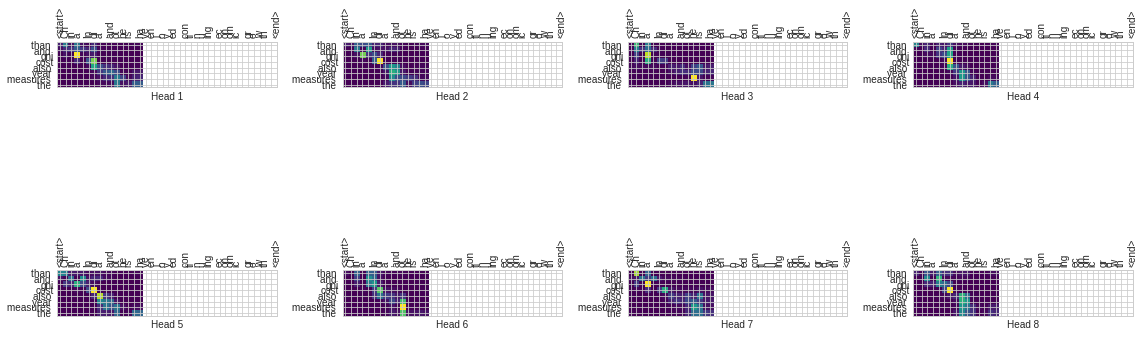

Input sentence:  China, India, and others have enjoyed continuing economic growth.
predicted_seq_index:  [<tf.Tensor: shape=(), dtype=int32, numpy=45>, <tf.Tensor: shape=(), dtype=int32, numpy=5>, <tf.Tensor: shape=(), dtype=int32, numpy=3970>, <tf.Tensor: shape=(), dtype=int32, numpy=1506>, <tf.Tensor: shape=(), dtype=int32, numpy=60>, <tf.Tensor: shape=(), dtype=int32, numpy=255>, <tf.Tensor: shape=(), dtype=int32, numpy=780>, <tf.Tensor: shape=(), dtype=int32, numpy=2>]
predicted_sentence:  中国、印度和其他国家都拥有经济增长。


In [ ]:
translate_zh_en(sentence="China, India, and others have enjoyed continuing economic growth.",plot='decoder_layer4_block2')

In [ ]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  1840000   
_________________________________________________________________
decoder (Decoder)            multiple                  2109696   
_________________________________________________________________
dense_64 (Dense)             multiple                  1059606   
Total params: 5,009,302
Trainable params: 5,009,302
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import matplotlib as mpl
# 你可能會需要自行下載一個中文字體檔案以讓 matplotlib 正確顯示中文
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/SimHei/simhei.ttf')
plt.style.use("seaborn-whitegrid")

# 這個函式將英 -> 中翻譯的注意權重視覺化（注意：我們將注意權重 transpose 以最佳化渲染結果
def plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=None):
    
  fig = plt.figure(figsize=(17, 7))
  
  sentence = tokenizer_en.encode(sentence)
  
  # 只顯示中文序列前 `max_len_tar` 個字以避免畫面太過壅擠
  if max_len_tar:
    predicted_seq = predicted_seq[:max_len_tar]
  else:
    max_len_tar = len(predicted_seq)
  
  # 將某一個特定 Decoder layer 裡頭的 MHA 1 或 MHA2 的注意權重拿出來並去掉 batch 維度
  attention_weights = tf.squeeze(attention_weights[layer_name], axis=0)  
  # (num_heads, tar_seq_len, inp_seq_len)
  
  # 將每個 head 的注意權重畫出
  for head in range(attention_weights.shape[0]):
    ax = fig.add_subplot(2, 4, head + 1)

    # [注意]我為了將長度不短的英文子詞顯示在 y 軸，將注意權重做了 transpose
    attn_map = np.transpose(attention_weights[head][:max_len_tar, :])
    ax.matshow(attn_map, cmap='viridis')  # (inp_seq_len, tar_seq_len)
    
    fontdict = {"fontproperties": zhfont}
    
    ax.set_xticks(range(max(max_len_tar, len(predicted_seq))))
    ax.set_xlim(-0.5, max_len_tar -1.5)
    
    ax.set_yticks(range(len(sentence) + 2))
    ax.set_xticklabels([tokenizer_zh.decode([i]) for i in predicted_seq 
                        if i < tokenizer_zh.vocab_size], 
                       fontdict=fontdict, fontsize=18)    
    
    ax.set_yticklabels(
        ['<start>'] + [tokenizer_en.decode([i]) for i in sentence] + ['<end>'], 
        fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head + 1))
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
  
  plt.tight_layout()
  plt.show()
  plt.close(fig)

In [ ]:
sentence = "China, India, and others have enjoyed continuing economic growth."
predicted_seq, attention_weights = evaluate(sentence)
layer_name = f"decoder_layer{num_layers}_block2"
plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=18)

FileNotFoundError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fa27b6d05f0> (for post_execute):


FileNotFoundError: ignored

FileNotFoundError: ignored

<Figure size 1224x504 with 8 Axes>